# Ion stress response

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


Load

In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base_mu = bsub.solution.f

## ME-model simulations

In [3]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [4]:
ions = ['na1_e','ca2_e','zn2_e','k_e']

Add ion uptake through osmosis

In [5]:
for ion in ions:
    old_ion = me.metabolites.get_by_id(ion)
    ion_base = ion.split('_')[0]
    # Close old exchange
    me.reactions.get_by_id('EX_{}'.format(ion)).lower_bound = 0
    me.reactions.get_by_id('EX_{}'.format(ion)).upper_bound = 0
    
    # Create new in/out metabolites
    ion_in = cobrame.Metabolite(id='{}_in'.format(ion_base))
    ion_out = cobrame.Metabolite(id='{}_out'.format(ion_base))
    
    # Ion uptake (creation, closed for now)
    rxn = cobrame.MEReaction(id='EX_{}_in'.format(ion_base))
    rxn.add_metabolites({
        ion_in:-1.0
    })
    me.add_reaction(rxn)
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    
    # Ion exit
    rxn = cobrame.MEReaction(id='DM_{}_out'.format(ion_base))
    rxn.add_metabolites({
        ion_out:-1.0
    })
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    me.add_reaction(rxn)
    
    # Replace old met
    uptake_rxns = get_reactions_of_met(me,ion,s = -1,verbose=0)
    exit_rxns = get_reactions_of_met(me,ion,s = 1,verbose=0)

    for rxn in uptake_rxns:
        coeff = rxn.pop(old_ion)
        rxn.add_metabolites({ion_in:coeff})
    for rxn in exit_rxns:
        coeff = rxn.pop(old_ion)
        rxn.add_metabolites({ion_out:coeff})

In [6]:
def single_flux_response(me,rate,ion,mu_fix=False):
    ion_base = ion.split('_')[0]
    me.reactions.get_by_id('EX_{}_in'.format(ion_base)).lower_bound = rate
    me.reactions.get_by_id('EX_{}_in'.format(ion_base)).upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [7]:
# Calculation at several sodium uptake rates
all_rxns = [rxn.id for rxn in me.reactions]
ion_rates = -np.arange(0,1,0.1)

print('Ions to include: {}'.format(ions))
print('Rates to use: {}'.format(ion_rates))

ion_result_macrodict = dict()

import multiprocessing as mp
NP = min([len(ion_rates),10])

Ions to include: ['na1_e', 'ca2_e', 'zn2_e', 'k_e']
Rates to use: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5 -0.6 -0.7 -0.8 -0.9]


In [8]:
# Parallel processing
pbar = tqdm(total=len(ions)*len(ion_rates))
for ion in ions:  
    flux_dict = {}  
    pbar.set_description('Calculating {} ({} threads)'.format(ion,NP))
    def collect_result(result):
        pbar.update(1)
        flux_dict[result[0]] = result[1]
        
    pool = mp.Pool(NP)
    for rate in ion_rates:
        pool.apply_async(single_flux_response, args=(me,rate,ion), callback=collect_result)
    pool.close()
    pool.join()
    ion_result_macrodict[ion] = flux_dict
    flux_responses_me = pd.DataFrame.from_dict(flux_dict)
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
    flux_responses_me.to_csv('{}_flux_responses.csv'.format(ion))

Calculating na1_e (10 threads):   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
ion_result_macrodict['k_e'].keys()

dict_keys([-10, -20, -30])

In [15]:
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

plt.figure(figsize=(5,4))
for idx,ion in enumerate(ions):
    ion_base = ion.split('_')[0]
    flux_responses_me = pd.DataFrame.from_dict(ion_result_macrodict[ion])
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]

    plt.plot(-flux_responses_me.loc['EX_{}_in'.format(ion_base)],flux_responses_me.loc['biomass_dilution'],
                label = ion,marker = next(marker),markersize=8)
    plt.xlabel('Ion uptake')
    plt.ylabel('Growth rate')
plt.legend()
plt.tight_layout()

KeyError: 'EX_na1_in'

<Figure size 360x288 with 0 Axes>

It appers that the icnrease davailability of ionstends to favor growth for Na and Ca. Zn does not change much. Potassium seems to greatly decrease. Is it due to the transporter expression?

In [58]:
_ = get_reactions_of_met(me,'k_c'.replace('_c','_e'),s=0,verbose=1)

( CD2t4_FWD_BSU26650-MONOMER 0 999999.0 ) 	 cd2_c + h_e + k_e <=> -4.27350427350427e-6*mu BSU26650-MONOMER + cd2_e + h_c + k_c
( ZN2t4_FWD_BSU26650-MONOMER 0 999999.0 ) 	 h_e + k_e + zn2_c <=> -0.000101383203279485*mu BSU26650-MONOMER + h_c + k_c + zn2_e
( EX_k_e -999999.0 999999.0 ) 	 k_e <=> 
( Kt3r_FWD_CPLX8J2-158 0 999999.0 ) 	 h_e + k_c <=> -2.5701099514183e-5*mu CPLX8J2-158 + h_c + k_e
( Kt1_REV_BSU31322-MONOMER 0 999999.0 ) 	 k_c <=> -3.40454651084207e-5*mu BSU31322-MONOMER + k_e
( Kt1_FWD_BSU31322-MONOMER 0 999999.0 ) 	 k_e <=> -3.40454651084207e-5*mu BSU31322-MONOMER + k_c
( Kt2r_FWD_BSU26640-MONOMER 0 999999.0 ) 	 h_e + k_e <=> -9.16356395098642e-5*mu BSU26640-MONOMER + h_c + k_c
( Kt2r_FWD_CPLX8J2-165 0 999999.0 ) 	 h_e + k_e <=> -4.27350427350427e-6*mu CPLX8J2-165 + h_c + k_c


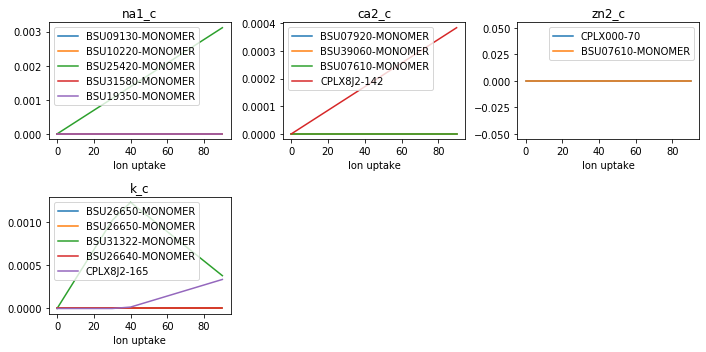

In [54]:
plt.figure(figsize=(10,5))
for idx,ion in enumerate(ions):
    plt.subplot(2,3,idx+1)
    flux_responses_me = pd.DataFrame.from_dict(ion_result_macrodict[ion])
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
    
    transport_rxns = get_reactions_of_met(me,ion.replace('_c','_e'),s=-1,verbose=0)
    for rxn in transport_rxns:
        if not hasattr(rxn,'complex_data'):
            continue
        complex_id = rxn.complex_data.complex.id
        formation_id = 'formation_{}'.format(complex_id)
        plt.plot(-flux_responses_me.loc['EX_{}_osm'.format(ion)],
                 flux_responses_me.loc[formation_id]/flux_responses_me.loc['biomass_dilution'],
                 label = complex_id)
    plt.xlabel('Ion uptake')
    plt.title(ion)
    plt.legend()
plt.tight_layout()

In [10]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

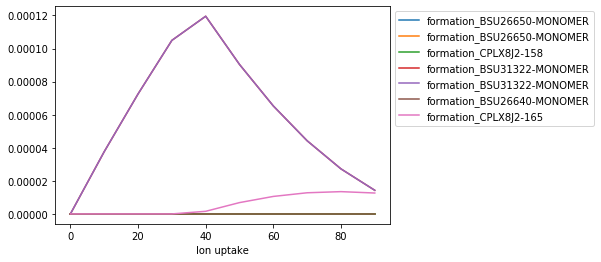

In [33]:
ion = 'k_c'
flux_responses_me = pd.DataFrame.from_dict(ion_result_macrodict[ion])
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
transport_rxns = get_reactions_of_met(me,ion.replace('_c','_e'),verbose=0)
for rxn in transport_rxns:
    if not hasattr(rxn,'complex_data'):
        continue
    complex_id = rxn.complex_data.complex.id
    formation_id = 'formation_{}'.format(complex_id)
    
    plt.plot(-flux_responses_me.loc['EX_{}_osm'.format(ion)],flux_responses_me.loc[formation_id],
                label = formation_id)
    plt.xlabel('Ion uptake')
plt.legend(bbox_to_anchor=(1, 1))

In [23]:
rxn

<MEReaction EX_k_e at 0x7f8e0881dac8>

Text(0.5, 1.0, "['ktrB', 'ktrA']")

<Figure size 1080x288 with 0 Axes>

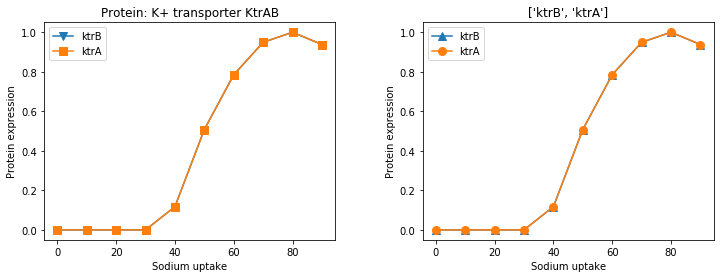

In [13]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-20] = 0

plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
genes = ['ktrB','ktrA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_k_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('Protein: K+ transporter KtrAB')

plt.subplot(1,2,2)
genes = ['ktrB','ktrA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_k_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title(genes)